In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sys
from tqdm.notebook import tqdm

sys.path.append('..')
from utils import *

In [161]:
data_path = '../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
sample_interval = get_sample_interval(f, 'ms')

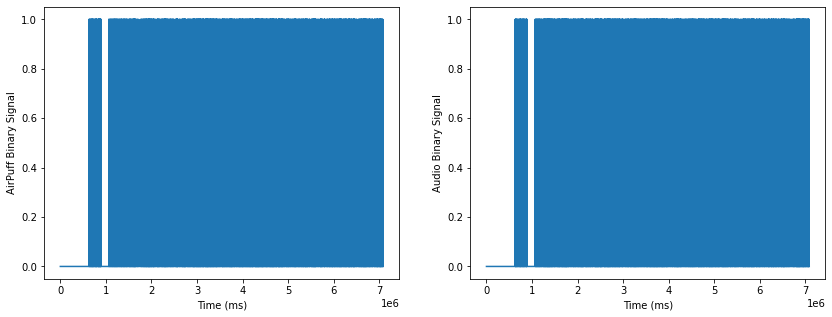

In [4]:
airPuff_binary, audio_binary = get_binary_signals(f)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(airPuff_binary)
plt.xlabel('Time (ms)')
plt.ylabel('AirPuff Binary Signal')

plt.subplot(1, 2, 2)
plt.plot(audio_binary)
plt.xlabel('Time (ms)')
plt.ylabel('Audio Binary Signal')

plt.show()

### How long are puffs? How long are tones?

In [70]:
puff_durations = []
puff_onsets = []
current_duration = 0
counting = False
puff_changes = np.diff(airPuff_binary)
for t, val in enumerate(puff_changes):
    if val == 1:
        counting = True
        puff_onsets.append(t)
    elif val == -1:
        counting = False
        puff_durations.append(current_duration)
        current_duration = 0
    if counting:
        current_duration += 1

the mean puff duration is 106.892 ms with a standard deviation of 1.044 ms


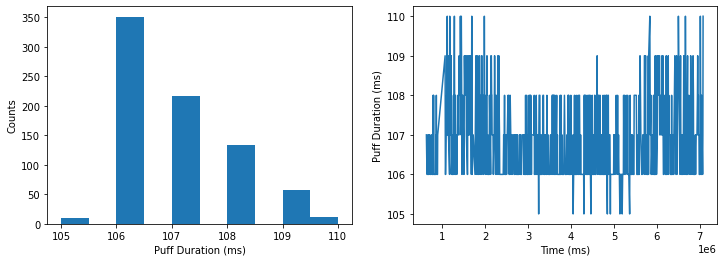

In [72]:
print(f"the mean puff duration is {np.mean(puff_durations):.3f} ms with a standard deviation of {np.std(puff_durations):.3f} ms")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(puff_durations)
plt.xlabel('Puff Duration (ms)')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
plt.plot(puff_onsets, puff_durations)
plt.xlabel('Time (ms)')
plt.ylabel('Puff Duration (ms)')

plt.show()

In [73]:
tone_durations = []
tone_onsets = []
current_duration = 0
counting = False
tone_changes = np.diff(audio_binary)
for t, val in enumerate(tone_changes):
    if val == 1:
        counting = True
        tone_onsets.append(t)
    elif val == -1:
        counting = False
        tone_durations.append(current_duration)
        current_duration = 0
    if counting:
        current_duration += 1

the mean tone duration is 500.000 ms with a standard deviation of 0.000 ms


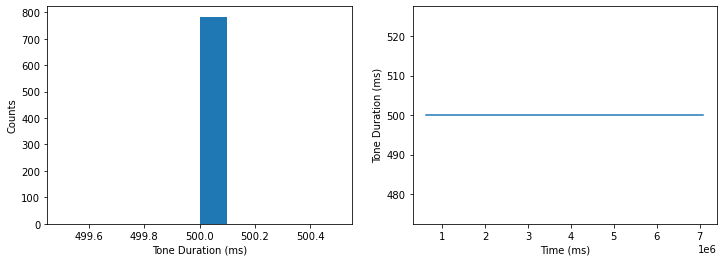

In [74]:
print(f"the mean tone duration is {np.mean(tone_durations):.3f} ms with a standard deviation of {np.std(tone_durations):.3f} ms")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(tone_durations)
plt.xlabel('Tone Duration (ms)')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
plt.plot(tone_onsets, tone_durations)
plt.xlabel('Time (ms)')
plt.ylabel('Tone Duration (ms)')


plt.show()

## Set Up Stimuli

In [247]:
sample_interval

1.0

In [263]:
stimuli = {}
for stim_name, stim in [('AirPuff Binary', airPuff_binary), ('Audio Binary', audio_binary)]:
    stim_begin = (np.diff(stim) == 1).astype(np.int)
    stim_end = (np.diff(stim) == -1).astype(np.int)
    stimuli[stim_name + ' (From Start)'] = stim_begin
    stimuli[stim_name + ' (From End)'] = stim_end

# both and separate
tone_only_begin = np.zeros(len(stim))
tone_only_end = np.zeros(len(stim))
puff_only_begin = np.zeros(len(stim))
puff_only_end = np.zeros(len(stim))
both_begin = np.zeros(len(stim))
both_end = np.zeros(len(stim))
count = 0
for t, (puffOn, toneOn) in enumerate(zip(f['trialInfo']['cpt_puffOn'][:, 0], f['trialInfo']['cpt_toneOn'][:, 0])):
    if np.isnan(puffOn):
        tone_only_begin[int(toneOn*1000)] = 1
        tone_only_end[int(f['trialInfo']['cpt_toneOff'][t, 0]*1000)] = 1
    elif np.isnan(toneOn):
        puff_only_begin[int(puffOn*1000)] = 1
        puff_only_end[int(f['trialInfo']['cpt_puffOff'][t, 0]*1000)] = 1
    else: # both are on
        count += 1
        both_begin[int(np.min([toneOn, puffOn])*1000)] = 1
        both_end[int(np.max([f['trialInfo']['cpt_toneOff'][t, 0], f['trialInfo']['cpt_puffOff'][t, 0]])*1000)] = 1
stimuli['Tone Only (From Start)'] = tone_only_begin
stimuli['Tone Only (From End)'] = tone_only_end
stimuli['Puff Only (From Start)'] = puff_only_begin
stimuli['Puff Only (From End)'] = puff_only_end
stimuli['Tone and Puff (From Start)'] = both_begin
stimuli['Tone and Puff (From End)'] = both_end

## Percent of Spikes Preceded By A Stimulus


In [170]:
phase_ranges = get_phase_ranges(f)
sta_length = 300
num_units = get_num_units(f)

iterator = tqdm(total=2*num_units)

preceding_stimulus_pct = {}
for stim_name, stimulus in [('AirPuff Binary', airPuff_binary), ('Audio Binary', audio_binary)]:
    preceding_stimulus_pct[stim_name] = []
    for unit_index in range(num_units):
        preceding_stimulus_pct[stim_name].append({})
        unit_spikes = get_unit_spikes(unit_index, f)
        spike_times = unit_spikes['spike_times']
        preceding_stimulus_pct[stim_name][-1]['area'] = unit_spikes['area']
        preceding_stimulus_pct[stim_name][-1]['hemisphere'] = unit_spikes['hemisphere']
        preceding_stimulus_pct[stim_name][-1]['stats'] = {}
        for phase in phase_ranges.keys():
            preceding_stimulus_pct[stim_name][-1]['stats'][phase] = {}
            sta_window = int(sta_length / sample_interval)
            relevant_spikes = spike_times[spike_times >= sta_length * 0.001]
            if phase_ranges[phase] is not None:
                indices = np.array([False] * len(relevant_spikes))
                for segment in phase_ranges[phase]:
                    indices = np.logical_or(indices,
                                            np.logical_and(relevant_spikes >= segment[0], relevant_spikes < segment[1]))
                relevant_spikes = relevant_spikes[indices]
            
            preceding_stimulus_pct[stim_name][-1]['stats'][phase]['preceding_zeros'] = []
            for spike_t in relevant_spikes:
                spike_t_step = int(spike_t * 1000 / sample_interval)
                preceding_stimulus_pct[stim_name][-1]['stats'][phase]['preceding_zeros'].append((stimulus[spike_t_step - sta_window:spike_t_step] == 0).sum())
    
        iterator.update()
iterator.close()

In [178]:
areas = ['vlPFC', '7b', 'CPB', 'FEF']
area_aggregate_preceding_zeros = {'Audio Binary': {}, 'AirPuff Binary': {}}

for stim_name in area_aggregate_preceding_zeros.keys():
    for area in areas:
        area_aggregate_preceding_zeros[stim_name][area] = {}
        for phase in phase_ranges.keys():
            area_aggregate_preceding_zeros[stim_name][area][phase] = []
        for unit_info in preceding_stimulus_pct[stim_name]:
            if unit_info['area'] == area:
                for phase in unit_info['stats']:
                    area_aggregate_preceding_zeros[stim_name][area][phase].extend(unit_info['stats'][phase]['preceding_zeros'])

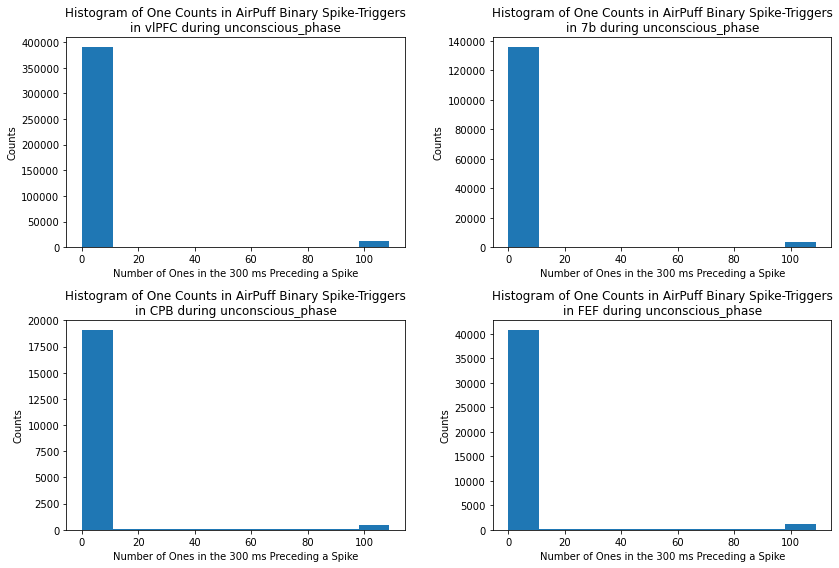

In [440]:
plt.figure(figsize=(12, 8))
plot_count = 1
stim_name = 'AirPuff Binary'
phase = 'unconscious_phase'
for i, area in enumerate(areas):
    plt.subplot(2, 2, i + 1)
    plt.hist(sta_length - np.array(area_aggregate_preceding_zeros[stim_name][area][phase]), density=False)
    plt.title(f"Histogram of One Counts in {stim_name} Spike-Triggers\nin {area} during {phase}")
    plt.xlabel("Number of Ones in the 300 ms Preceding a Spike")
    plt.ylabel("Counts")
plt.tight_layout()
plt.show()

## Evoked Repsonse Potential - Firing Rate

In [322]:
erp_length = 1500
phase_ranges = get_phase_ranges(f)
num_units = get_num_units(f)
test_duration = get_test_duration(f)
stride = 50 # ms

erp_steps = int(np.ceil(erp_length/stride)) + 1

erps = []
for unit_index in tqdm(range(num_units)):
    erps.append({})
    unit_spikes = get_unit_spikes(unit_index, f)
    spike_times = unit_spikes['spike_times']
    erps[-1]['area'] = unit_spikes['area']
    erps[-1]['hemisphere'] = unit_spikes['hemisphere']
    
    firing_rate, bin_locations = spike_times_to_firing_rate(spike_times, window=250, stride=stride, test_duration=test_duration)
    spike_dirac = np.zeros(len(audio_binary))
    for t in spike_times:
        spike_dirac[int(t*1000)] = 1
    
    for stim_name, stimulus in stimuli.items():
        erps[-1][stim_name] = {}
        for phase in phase_ranges.keys():
            erps[-1][stim_name][phase] = {'erp_fr': np.zeros(erp_steps), 'erp_spikes': np.zeros(erp_length), 'succeeding_ones': [], 'num_events': 0}
        
        for t, val in enumerate(stimulus):
            if val:
                for phase, phase_range in phase_ranges.items():
                    event_loc = np.argmax(bin_locations > t/1000) - 1
                    event_end = event_loc + int(np.ceil(erp_length/stride)) + 1
                    for segment in phase_range:
                        if t*0.001 >= segment[0] and (t + erp_length)*0.001 <= segment[1]:
                            erps[-1][stim_name][phase]['erp_fr'] += firing_rate[event_loc:event_end]
                            erps[-1][stim_name][phase]['erp_spikes'] += spike_dirac[t:t + erp_length]
                            erps[-1][stim_name][phase]['succeeding_ones'].append(erp_length - (spike_dirac[t:t + erp_length] == 0).sum())
                            erps[-1][stim_name][phase]['num_events'] += 1
    
        for phase in phase_ranges.keys():
            if erps[-1][stim_name][phase]['num_events'] == 0:
                print(f"{stim_name} {phase}: {erps[-1][stim_name][phase]['num_events']} events")
            erps[-1][stim_name][phase]['erp_fr'] /= erps[-1][stim_name][phase]['num_events']
            erps[-1][stim_name][phase]['erp_spikes'] /= erps[-1][stim_name][phase]['num_events']

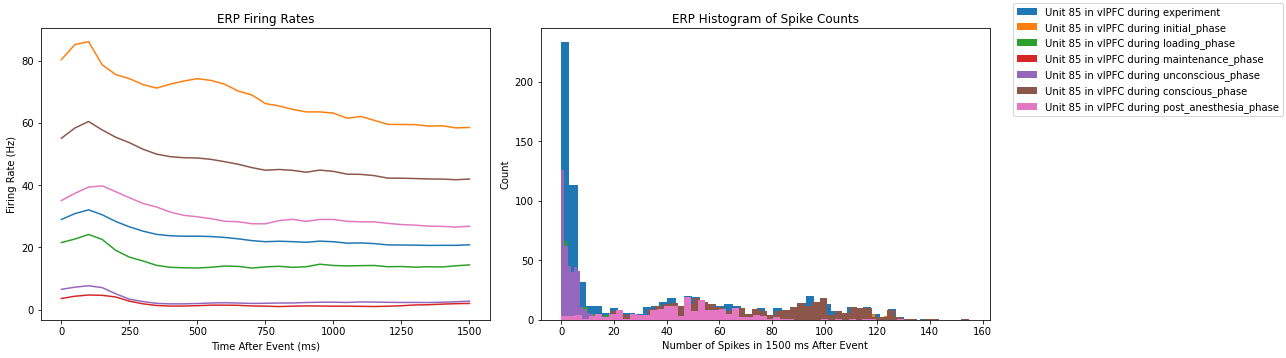

In [443]:
stim_name = 'AirPuff Binary (From Start)'

# plot_items = [
#     dict(
#         unit_index=0,
#         phase='conscious_phase',
#         stim_name=stim_name,
#     ),
#     dict(
#         unit_index=155,
#         phase='conscious_phase',
#         stim_name=stim_name,
#     )
# ]

unit_index = 85
plot_items = []
for phase in phase_ranges.keys():
    plot_items.append(dict(
        unit_index=unit_index,
        phase=phase,
        stim_name=stim_name,
    ))

fig = plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for plot_item in plot_items:
    plt.plot(erps[plot_item['unit_index']][plot_item['stim_name']][plot_item['phase']]['erp_fr'], label=f"Unit {plot_item['unit_index']} in {erps[plot_item['unit_index']]['area']} during {plot_item['phase']}")
plt.xlabel('Time After Event (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.xticks(np.linspace(0, erp_steps - 1, 7), [int(val) for val in np.linspace(0, erp_steps - 1, 7)*stride])
plt.title('ERP Firing Rates')

plt.subplot(1, 2, 2)
for plot_item in plot_items:
    plt.hist(erps[plot_item['unit_index']][plot_item['stim_name']][plot_item['phase']]['succeeding_ones'], bins=50, label=f"Unit {plot_item['unit_index']} in {erps[plot_item['unit_index']]['area']} during {plot_item['phase']}")
plt.xlabel(f'Number of Spikes in {erp_length} ms After Event')
plt.ylabel('Count')
plt.title('ERP Histogram of Spike Counts')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

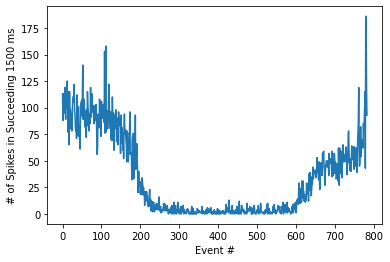

In [442]:
plt.plot(erps[85][plot_item['stim_name']]['experiment']['succeeding_ones'])
# plt.plot(np.arange(sum(stimuli[plot_item['stim_name']])), erps[200][plot_item['stim_name']]['experiment']['succeeding_ones'])
plt.xlabel('Event #')
plt.ylabel('# of Spikes in Succeeding 1500 ms')
plt.show()

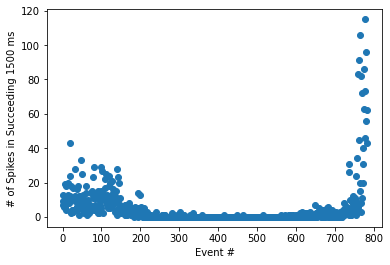

In [437]:
# plt.plot(erps[85][plot_item['stim_name']]['experiment']['succeeding_ones'])
for i in range()
    plt.scatter(np.arange(sum(stimuli[plot_item['stim_name']])), erps[200][plot_item['stim_name']]['experiment']['succeeding_ones'])
plt.xlabel('Event #')
plt.ylabel('# of Spikes in Succeeding 1500 ms')
plt.show()

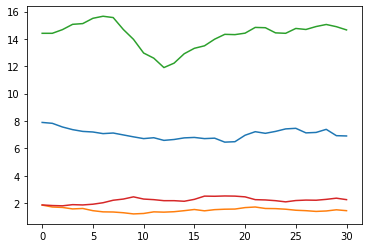

In [324]:
stim_name = 'Audio Binary (From End)'
phase = 'conscious_phase'
plt.plot(erps[0][stim_name][phase]['erp_fr'])
plt.plot(erps[1][stim_name][phase]['erp_fr'])
plt.plot(erps[2][stim_name][phase]['erp_fr'])
plt.plot(erps[3][stim_name][phase]['erp_fr'])
plt.show()

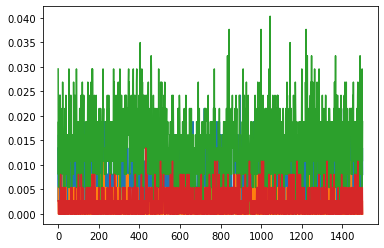

In [320]:
stim_name = 'Audio Binary (From End)'
phase = 'conscious_phase'
plt.plot(erps[0][stim_name][phase]['erp_spikes'])
plt.plot(erps[1][stim_name][phase]['erp_spikes'])
plt.plot(erps[2][stim_name][phase]['erp_spikes'])
plt.plot(erps[3][stim_name][phase]['erp_spikes'])

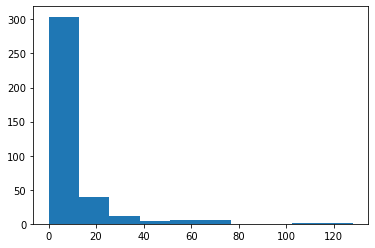

In [341]:
stim_name = 'Audio Binary (From End)'
phase = 'conscious_phase'
# plt.hist(erps[0][stim_name][phase]['succeeding_ones'])
# plt.hist(erps[1][stim_name][phase]['succeeding_ones'])
# plt.hist(erps[2][stime_name][phase]['succeeding_ones'])
plt.hist(erps[200][stim_name][phase]['succeeding_ones'])
plt.hist(erps[200][stim_name][phase]['succeeding_ones'])
plt.show()